In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import cv2
import os
from tqdm.notebook import tqdm
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [3]:
#!unzip -qq /content/drive/'My Drive'/Code/tomatoes.zip

In [4]:
dataset_path = '/content/PlantVillage'

class_name = []
images = []
labels = []
for index, folder in enumerate(os.listdir(dataset_path)):
  class_name.append(folder)
  image_path = os.path.join(dataset_path, folder)
  # print(image_path, len(os.listdir(image_path)))
  for image in os.listdir(image_path):
    labels.append(index)
    images.append(os.path.join(dataset_path, folder, image))

X = []
for index, path in enumerate(tqdm(images)):
  try:
    X.append(cv2.resize(cv2.imread(path),dsize=(256,256)))
  except:
    labels.pop(index)
X = np.array(X)
y = np.array(labels)
Y = to_categorical(y, num_classes=len(class_name))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,stratify = Y, shuffle=True, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, shuffle=True, random_state=100)
print(X_train.shape, X_test.shape,X_val.shape)
print(y_train.shape, y_test.shape,y_val.shape)

(9902, 256, 256, 3) (1238, 256, 256, 3) (1238, 256, 256, 3)
(9902, 5) (1238, 5) (1238, 5)


In [6]:
def get_model():
    inceptionv3 = InceptionV3(weights='imagenet', include_top=False)

    input = Input(shape=(256, 256, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = inceptionv3(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='softmax', name='predictions')(x)
    # multi output
    output = Dense(5,activation = 'softmax', name='root')(x)

    # Compile
    model = Model(input, x)
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    

    return model


inceptionv3 = get_model()

filepath="/content/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
    rescale=1./255,
	width_shift_range=0.1,
    height_shift_range=0.1,
	horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

aug_val = ImageDataGenerator(rescale=1./255)

history=inceptionv3.fit(aug.flow(X_train, y_train, batch_size=32),
                               epochs=25, steps_per_epoch=len(X_train)//32,
                               validation_data=aug.flow(X_val,y_val,
                               batch_size=128), callbacks=callbacks_list)


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 256, 256, 3)       84        
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)              

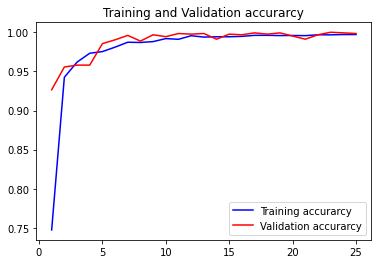

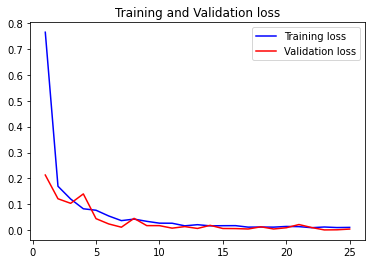

In [7]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [9]:
from keras.models import load_model
for i in range(1,10):
  modellink = '/content/weights-' + '0' + str(i) + '.hdf5'
  model = load_model(modellink)
  scores = model.evaluate(X_test, y_test)
  print(f"Test Accuracy: {scores[1]*100}")
for i in range(10,26):
  modellink = '/content/weights-' + str(i) + '.hdf5'
  model = load_model(modellink)
  scores = model.evaluate(X_test, y_test)
  print(f"Test Accuracy: {scores[1]*100}")

39/39 [==============================] - 2s 64ms/step - loss: 129.7628 - accuracy: 0.2593
Test Accuracy: 25.92891752719879
39/39 [==============================] - 2s 55ms/step - loss: 134.4819 - accuracy: 0.2593
Test Accuracy: 25.92891752719879
39/39 [==============================] - 2s 55ms/step - loss: 99.2205 - accuracy: 0.2593
Test Accuracy: 25.92891752719879
39/39 [==============================] - 2s 55ms/step - loss: 129.3627 - accuracy: 0.2593
Test Accuracy: 25.92891752719879
39/39 [==============================] - 2s 55ms/step - loss: 114.8195 - accuracy: 0.2593
Test Accuracy: 25.92891752719879
39/39 [==============================] - 2s 55ms/step - loss: 160.3345 - accuracy: 0.2593
Test Accuracy: 25.92891752719879
39/39 [==============================] - 2s 55ms/step - loss: 176.3750 - accuracy: 0.2593
Test Accuracy: 25.92891752719879
39/39 [==============================] - 2s 55ms/step - loss: 118.9008 - accuracy: 0.2472
Test Accuracy: 24.717286229133606
39/39 [=========